# Setup

## Load with astroNN


In [1]:
from astroNN.datasets import galaxy10
from astroNN.datasets.galaxy10 import galaxy10cls_lookup
from sklearn.model_selection import StratifiedShuffleSplit
# from tensorflow.keras import utils
import numpy as np
from matplotlib import pyplot as plt

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score



WARNING! APOGEE environment variable SDSS_LOCAL_SAS_MIRROR not set
WARNING! Gaia environment variable GAIA_TOOLS_DATA not set


In [141]:

#jrv: this codes are from here https://github.com/henrysky/astroNN/blob/master/demo_tutorial/galaxy10/Galaxy10_Tutorial.ipynb


# To load images and labels (will download automatically at the first time)
# First time downloading location will be ~/.astroNN/datasets/

images, labels = galaxy10.load_data()

smaller_size_for_my_weak_pc = 1000
images, labels = images[:smaller_size_for_my_weak_pc], labels[:smaller_size_for_my_weak_pc]

if (np.unique(labels)!=np.arange(10)).all(): #if this is true it means that when making the sample smaller we did not get all the labels so we should take a bigger sample
    raise ValueError('Not all of the labels are in the smaller sample')

# # To convert the labels to categorical 10 classes
# labels = utils.to_categorical(labels, 10)




# Select 10 (np.unique(labels)!=np.arange(10)).all()of the images to inspect
# img = None
# plt.ion()
# print('===================Data Inspection===================')
# # for counter, i in enumerate(range(np.random.randint(0, labels.shape[0], size=10).shape[0])):
# for counter, i in enumerate(range(np.random.randint(0, labels.shape[0], size=1).shape[0])):
#     img = plt.imshow(images[i])
#     plt.title('Class {}: {} \n Random Demo images {} of 10'.format(np.argmax(labels[i]), galaxy10cls_lookup(labels[i]), counter+1))
#     plt.draw()
#     plt.pause(2.)
# plt.close('all')
# print('===============Data Inspection Finished===============')
#
#
#

# # To convert to desirable type
# labels = labels.astype(np.float32)
# images = images.astype(np.float32)

C:\Users\jaime\.astroNN\datasets\Galaxy10.h5 was found!


# Starting here taken from exercise 10 chapter 9 Hands on Ml

## First attempt

In [142]:
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
images = images.reshape(images.shape[0],-1)

train_valid_idx, test_idx = next(strat_split.split(images, labels))
X_train_valid = images[train_valid_idx]
y_train_valid = labels[train_valid_idx]
X_test = images[test_idx]
y_test = labels[test_idx]

strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=43)
train_idx, valid_idx = next(strat_split.split(X_train_valid, y_train_valid))
X_train = X_train_valid[train_idx]
y_train = y_train_valid[train_idx]
X_valid = X_train_valid[valid_idx]
y_valid = y_train_valid[valid_idx]

In [143]:
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(640, 14283) (640,)
(160, 14283) (160,)
(200, 14283) (200,)


To speed things up, we’ll reduce the data’s dimensionality using PCA:

In [144]:
pca = PCA(0.99)
X_train_pca = pca.fit_transform(X_train)
X_valid_pca = pca.transform(X_valid)
X_test_pca = pca.transform(X_test)

Next, cluster the images using K-Means, and ensure that you have a good number of clusters (using one of the techniques discussed in this chapter)

In [145]:
from sklearn.cluster import KMeans

k_range = range(2,100,5) #DOUBT: how to know initially that the range makes sense till 150?
kmeans_per_k = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X_train_pca)
    kmeans_per_k.append(kmeans)

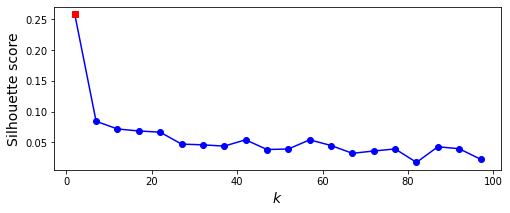

In [146]:
from sklearn.metrics import silhouette_score

silhouette_scores = [silhouette_score(X_train_pca, model.labels_)
                     for model in kmeans_per_k]
best_index = np.argmax(silhouette_scores)
best_k = k_range[best_index]
best_score = silhouette_scores[best_index]

plt.figure(figsize=(8, 3))
plt.plot(k_range, silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.plot(best_k, best_score, "rs")
plt.show()

Accourding to the Silhouette score the best number of clusters to choose is around 2. This initially does not look good since we know we are working with 10 different types of galaxies

(array([140., 323., 288.,  12.,  75.,   3.,  26.,  57.,  50.,  26.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

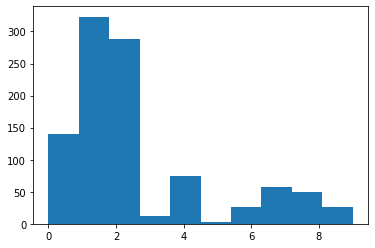

In [147]:
plt.hist(labels)

In the histogram for the labels we can see that this we have a very skewed distribution with a couple of galaxies being the most predominant. That might explain why we are getting such a low *k* with the silhouette score. To fix it we can resample in order to get a more balanced distribution of galaxies

## Second attempt


In [148]:
#here I take a random number of pictures (between 80 and 120) from each different kind of galaxy

images, labels = galaxy10.load_data()


C:\Users\jaime\.astroNN\datasets\Galaxy10.h5 was found!


In [149]:
new_images = np.empty((1,69,69,3))
new_labels = np.empty((1))
for cluster_id in np.unique(labels):
    # print("Cluster", cluster_id)
    images_in_this_cluster = images[labels == cluster_id]
    labels_in_this_cluster = labels[labels == cluster_id]
    size_sample_from_this_cluster = np.random.randint(15,20)
    temp_images = images_in_this_cluster[:size_sample_from_this_cluster]
    temp_labels = labels_in_this_cluster[:size_sample_from_this_cluster]
    print(len(temp_images), " images taken for type ", cluster_id)
    new_images = np.concatenate((new_images,temp_images),axis=0)
    new_labels = np.concatenate((new_labels,temp_labels),axis=0)

new_images = new_images[1:,:] #drop the first dimension what I initialized with np.empty so I could concatenate
new_labels = new_labels[1:] #drop the first dimension what I initialized with np.empty so I could concatenate

15  images taken for type  0
18  images taken for type  1
16  images taken for type  2
16  images taken for type  3
16  images taken for type  4
15  images taken for type  5
16  images taken for type  6
17  images taken for type  7
18  images taken for type  8
17  images taken for type  9


In [150]:
galaxy10cls_lookup(5)

'Disk, Edge-on, Boxy Bulge'

Now we have more or less the same number of galaxies from each type, besides for the type 5. That is simply because we do not have many pictures from 'Disk, Edge-on, Boxy Bulge' galaxies

In [151]:
new_images.shape

(164, 69, 69, 3)

(array([15., 18., 16., 16., 16., 15., 16., 17., 18., 17.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

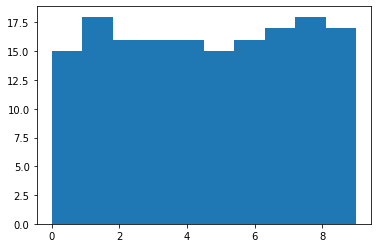

In [152]:

if (np.unique(labels)!=np.arange(10)).all(): #if this is true it means that when making the sample smaller we did not get all the labels so we should take a bigger sample
    raise ValueError('Not all of the labels are in the smaller sample')

plt.hist(new_labels)

Now the distribution looks better. Let's repeat the whole process of splitting, applying PCA, training and ploting the silhouette scores:

Here the shapes again for train, validation and test sets: 
(104, 14283) (104,)
(27, 14283) (27,)
(33, 14283) (33,)


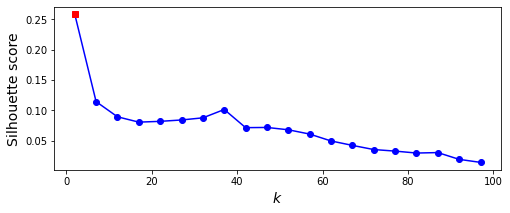

In [153]:

strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
new_images = new_images.reshape(new_images.shape[0],-1)

train_valid_idx, test_idx = next(strat_split.split(new_images, new_labels))
X_train_valid = new_images[train_valid_idx]
y_train_valid = new_labels[train_valid_idx]
X_test = new_images[test_idx]
y_test = new_labels[test_idx]

strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=43)
train_idx, valid_idx = next(strat_split.split(X_train_valid, y_train_valid))
X_train = X_train_valid[train_idx]
y_train = y_train_valid[train_idx]
X_valid = X_train_valid[valid_idx]
y_valid = y_train_valid[valid_idx]

print("Here the shapes again for train, validation and test sets: ")
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

pca = PCA(0.99)
X_train_pca = pca.fit_transform(X_train)
X_valid_pca = pca.transform(X_valid)
X_test_pca = pca.transform(X_test)

k_range = range(2,100,5) #DOUBT: how to know initially that the range makes sense till 150?
kmeans_per_k = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X_train_pca)
    kmeans_per_k.append(kmeans)

silhouette_scores = [silhouette_score(X_train_pca, model.labels_)
                     for model in kmeans_per_k]
best_index = np.argmax(silhouette_scores)
best_k = k_range[best_index]
best_score = silhouette_scores[best_index]

plt.figure(figsize=(8, 3))
plt.plot(k_range, silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.plot(best_k, best_score, "rs")
plt.show()

In [153]:
# XAKI : blocked because I do not know why it keeps decreasing. I posted it here https://stackoverflow.com/questions/71808028/silhouette-scores-for-clustering-decreases-with-k